In [ ]:
pip install transformers scikit-learn beautifulsoup4 newspaper3k requests

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 56.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 8.3 MB/s eta 0:00:00
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13540 sha256=5c2803c002b9ec76b5db225b240ea82005f49d253de485c6bfa7576bdc00b993
  Stored in directory: /root/.cache/pip/wheels/fc/ab/f8/cce3a9ae6d828bd346be695f7ff54612cd22b7cbd7208d68f3
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3341 sha256=90c37a808ca5bdf454d6f0a35d42b31b25bbb7060e1610d169396552dedeaed5
  Stored in directory: /root/.cache/pip/wheels/80/d5/72/9cd9eccc819636436c6a6e59c22a0fb1ec

In [ ]:
from transformers import pipeline

classifier = pipeline("text-classification", model="distilbert-base-uncased-finetuned-sst-2-english")

text = "NASA confirms aliens landed on Earth.Lunar surface may contain water molecules,study says.scientists confirm presence of water in sunlit areas of the moon"
result = classifier(text)
print(result)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


[{'label': 'POSITIVE', 'score': 0.9861331582069397}]


In [ ]:
def classify_news(text):
    result = classifier(text)[0]
    label = "REAL" if result['label'] == "POSITIVE" else "FAKE"
    score = round(result['score'] * 100, 2)
    return label, score

In [ ]:
import requests
from bs4 import BeautifulSoup

def fetch_google_news(query, max_results=5):
    url = f"https://news.google.com/search?q={query}&hl=en-IN&gl=IN&ceid=IN:en"
    headers = {"User-Agent": "Mozilla/5.0"}
    r = requests.get(url, headers=headers)
    soup = BeautifulSoup(r.text, "html.parser")
    links = soup.select("article h3 a")

    if not links:
        print("No news references found for this query.")

    headlines = [link.get_text() for link in links[:max_results]]
    return headlines

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def compute_fact_score(news_text, reference_texts):
    if not reference_texts:
        return 0.0
    texts = [news_text] + reference_texts
    tfidf = TfidfVectorizer().fit_transform(texts)
    sim_matrix = cosine_similarity(tfidf[0:1], tfidf[1:])
    return round(sim_matrix.mean() * 100, 2)

In [ ]:
def analyze_news(text):
    print("Classifying news...")
    label, confidence = classify_news(text)
    print(f"Prediction: {label} ({confidence}%)")

    print("\nSearching for similar headlines...")
    references = fetch_google_news(text[:100])
    if not references:
        print("No news references found for this query.")
        fact_score = confidence if label == "REAL" else 100 - confidence
        print(f"\nNo references — using model confidence as proxy.")
    else:
        print(f"Found {len(references)} similar headlines:")
        for ref in references:
            print("•", ref)
        fact_score = compute_fact_score(text, references)
        print(f"\nCalculating fact score...")

    print(f"Fact Score: {fact_score}/100")

    return {
        "prediction": label,
        "confidence": confidence,
        "fact_score": round(fact_score, 2),
        "evidence": references
    }

In [ ]:
pip install matplotlib

In [ ]:
import matplotlib.pyplot as plt
def plot_prediction(result):
    prediction = result['prediction']
    confidence = result['confidence']
    fact_score = result['fact_score']

    labels = ['Model Confidence', 'Fact Score']
    values = [confidence, fact_score]
    colors = ['green' if prediction == 'REAL' else 'red'] * 2

    plt.figure(figsize=(8, 5))
    bars = plt.bar(labels, values, color=colors, alpha=0.7)

    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, val + 2,
                 f"{val:.2f}%", ha='center', va='bottom', fontsize=12)

    plt.ylim(0, 110)
    plt.title(f"Prediction: {prediction} ({confidence:.2f}%)", fontsize=14)
    plt.ylabel("Score (%)")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

Classifying news...
Prediction: REAL (97.96%)

Searching for similar headlines...
No news references found for this query.
No news references found for this query.

No references — using model confidence as proxy.
Fact Score: 97.96/100


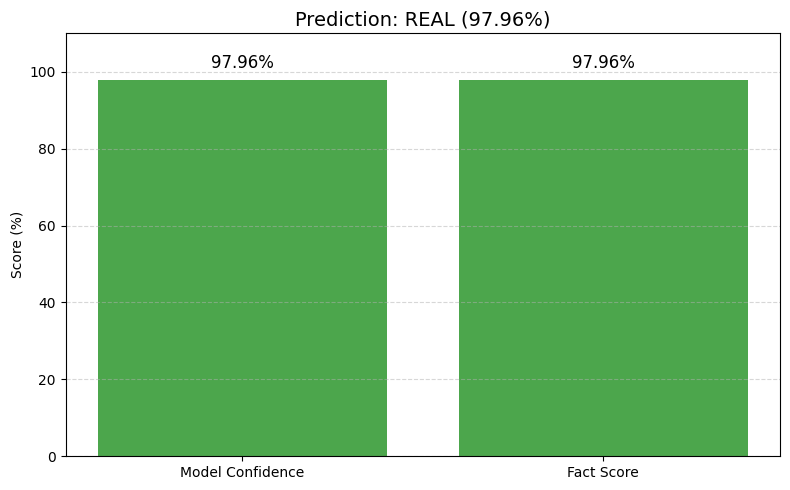

In [ ]:
news_input = "NASA finds evidence of water on the moon"
result = analyze_news(news_input)
plot_prediction(result)
